# This notebook implements sleeper agent attack

In this notebook, we will learn how to use ART to run a Hidden Trigger Backdoor Attack Sleeper Agent poisoning attack on a neural network trained with TensorFlow. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/pdf/2106.08970.pdf) by Hossein Souri, et. al. 2021.

# Data Normalization and Substitute Model Training 

In [2]:
import numpy as np
import os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art.estimators.classification import TensorFlowV2Classifier
from art.utils import load_cifar10

(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

min_ = (min_-mean)/(std+1e-7)
max_ = (max_-mean)/(std+1e-7)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.keras import TqdmCallback

tf.get_logger().setLevel('ERROR')

# Tweaked the model from https://github.com/calmisential/TensorFlow2.0_ResNet
# MIT License
def basic_block(x, filter_num, stride=1):
    conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                        kernel_size=(3, 3),
                                        strides=stride,
                                        padding="same")
    bn1 = tf.keras.layers.BatchNormalization()
    conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                        kernel_size=(3, 3),
                                        strides=1,
                                        padding="same")
    bn2 = tf.keras.layers.BatchNormalization()
    if stride != 1:
        downsample = tf.keras.Sequential()
        downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                    kernel_size=(1, 1),
                                                    strides=stride))
        downsample.add(tf.keras.layers.BatchNormalization())
    else:
        downsample = tf.keras.layers.Lambda(lambda x: x)

    residual = downsample(x)
    x = conv1(x)
    x = bn1(x)
    x = tf.nn.relu(x)
    x = conv2(x)
    x = bn2(x)
    output = tf.nn.relu(tf.keras.layers.add([residual, x]))
    return output

def basic_block_layer(x, filter_num, blocks, stride=1):
    x = basic_block(x, filter_num, stride=stride)
    for _ in range(1, blocks):
        x = basic_block(x, filter_num, stride=1)
    return x

def resnet(x, num_classes, layer_params):
    pad1 = tf.keras.layers.ZeroPadding2D(padding=1)
    conv1 = tf.keras.layers.Conv2D(filters=64,
                                        kernel_size=(3, 3),
                                        strides=1,
                                        padding="same")
    bn1 = tf.keras.layers.BatchNormalization()

    avgpool = tf.keras.layers.GlobalAveragePooling2D()
    fc = tf.keras.layers.Dense(units=num_classes, activation=tf.keras.activations.softmax)

    x = pad1(x)
    x = conv1(x)
    x = bn1(x)
    x = tf.nn.relu(x)
    x = basic_block_layer(x, filter_num=64,
                                        blocks=layer_params[0])
    x = basic_block_layer(x, filter_num=128,
                                        blocks=layer_params[1],
                                        stride=2)
    x = basic_block_layer(x, filter_num=256,
                                        blocks=layer_params[2],
                                        stride=2)
    x = basic_block_layer(x, filter_num=512,
                                        blocks=layer_params[3],
                                        stride=2)
    x = avgpool(x)
    output = fc(x)
    return output

def resnet_18(x, num_classes):
    return resnet(x, num_classes, layer_params=[2, 2, 2, 2])

def create_model(x_train, y_train, num_classes=10, batch_size=64, epochs=25, callbacks=[]):
    inputs = tf.keras.layers.Input(shape=x_train.shape[1:])  # Specify the dimensions
    outputs = resnet_18(inputs, num_classes)
    model = tf.keras.models.Model(inputs, outputs)

    opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False
        )
    
    datagen.fit(x_train)
    callbacks = callbacks + [TqdmCallback(verbose=0)]
    model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,verbose=0,callbacks=callbacks)
    return model
    
model_path = "../../../models/cifar10-resnet18-notebook.h5"
if not os.path.exists(model_path):
    model = create_model(x_train, y_train, epochs=80)
    model.save(model_path)
else:
    model = tf.keras.models.load_model(model_path)

model.evaluate(x_test, y_test)
K = 1000
# input_shape=(K,32, 32, 3)
input_shape=(32, 32, 3)
model_art = TensorFlowV2Classifier(model, nb_classes=10, input_shape=input_shape)

print("Model and data preparation done.")

2022-06-30 14:25:35.698900: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-30 14:25:39.933696: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-30 14:25:39.934866: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-30 14:25:39.951196: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:af:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-30 14:25:39.952259: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-

313/313 [==============================] - 17s 28ms/step - loss: 0.4124 - accuracy: 0.9133
Model and data preparation done.


# Load Trigger Patch

In [3]:
from PIL import Image
from numpy import asarray
from skimage.transform import resize

patch_size = 8
img = Image.open('trigger_10.png')
numpydata = asarray(img)
patch = resize(numpydata, (patch_size,patch_size,3))
patch = (patch-mean)/(std+1e-7)
x_train_orig = np.copy(x_train)

# Define Source and Target Class

In [4]:
class_source = 0
class_target = 1
K = 1000

# Select Triggers from Source Class and helper functions for calculating Success Rate

In [5]:
from art.utils import to_categorical

def select_trigger_train(x_train,y_train,K,class_source,class_target):
    x_train_ = np.copy(x_train)
    index_source = np.where(y_train.argmax(axis=1)==class_source)[0][0:K]
    index_target = np.where(y_train.argmax(axis=1)==class_target)[0]
    x_trigger = x_train_[index_source]
    y_trigger  = to_categorical([class_target], nb_classes=10)
    y_trigger = np.tile(y_trigger,(len(index_source),1))
    return x_trigger,y_trigger,index_target

In [6]:
x_trigger,y_trigger,index_target = select_trigger_train(x_train,y_train,K,class_source,class_target)

# Generate Poison Images through attack 

In [7]:
from art.attacks.poisoning.sleeper_agent_attack import SleeperAgentAttack
attack = SleeperAgentAttack(model_art,
                                percent_poison=0.10,
                                max_trials=1,
                                max_epochs=250,
                                learning_rate_schedule=(np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5]), [250, 350, 400, 430, 460]),
                                clip_values=(min_,max_),
                                epsilon=16/255 * (max_ - min_),
                                batch_size=500,
                                verbose=1,
                                indices_target=index_target,
                                patching_strategy="random",
                                selection_strategy="max-norm",
                                patch=patch,
                                retraining_factor = 4,
                                model_retrain = False,
                                model_retraining_epoch = 80,
                                class_source = class_source,
                                class_target = class_target
                           )
x_poison, y_poison = attack.poison(x_trigger,y_trigger,x_train,y_train,x_test,y_test) 
indices_poison = attack.get_poison_indices()

  0%|          | 0/1 [00:00<?, ?it/s]

0epoch [00:00, ?epoch/s]

Best B-score: 0.01162099838256836


In [8]:
model_poisoned = create_model(x_poison,y_poison,epochs=80)

0epoch [00:00, ?epoch/s]

In [13]:
model_poisoned(x_test,y_test)

TypeError: unhashable type: 'numpy.ndarray'

# Visualize Trigger, Original and Poisoned Images 

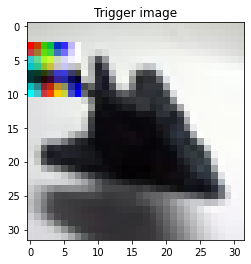

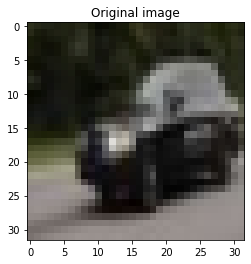

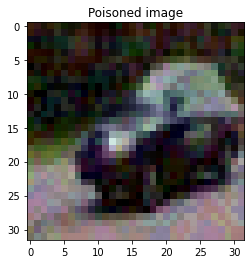

In [9]:
import matplotlib.pyplot as plt
plt.imshow(x_trigger[0]*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
plt.imshow(x_train_orig[index_target[indices_poison][0]]*(std+1e-7)+mean)
plt.title('Original image')
plt.show()

plt.imshow(x_poison[index_target[indices_poison][0]]*(std+1e-7)+mean)
plt.title('Poisoned image')
plt.show()

# Calculate Success Rate on x_train and x_test

In [10]:
def add_trigger_patch(x_set,patch_type="fixed"):
    img = Image.open('trigger_10.png')
    numpydata = asarray(img)
    patch = resize(numpydata, (8,8,3))
    patch = (patch-mean)/(std+1e-7)
    if patch_type == "fixed":
        x_set[:,-patch_size:,-patch_size:,:] = patch
    else:
        for x in x_set:
            x_cord = random.randrange(0,x.shape[1] - patch.shape[1] + 1)
            y_cord = random.randrange(0,x.shape[2] - patch.shape[2] + 1)
            x[x_cord:x_cord+patch_size,y_cord:y_cord+patch_size,:]=patch

    return x_set

# Calculate on train images

5000
Train Success Rate 0.0752


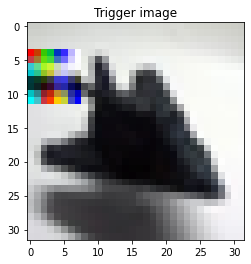

In [11]:
import random
index_source_train = np.where(y_train.argmax(axis=1)==class_source)[0]
x_train_trigger = x_train_orig[index_source_train]
x_train_trigger = add_trigger_patch(x_train_trigger,"random")
result_poisoned_train = model_poisoned(x_train_trigger)
print(len(result_poisoned_train))

success_train = (np.argmax(result_poisoned_train,axis=1)==1).sum()/result_poisoned_train.shape[0]
print("Train Success Rate",success_train)
plt.imshow(x_train_trigger[0]*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()

# Calculate Success Rate on Test 

1000
Test Success Rate: 0.096


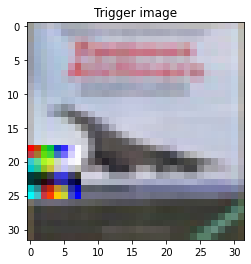

In [12]:
import random
index_source_test = np.where(y_test.argmax(axis=1)==class_source)[0]
x_test_trigger = x_test[index_source_test]
x_test_trigger = add_trigger_patch(x_test_trigger,"random")
result_poisoned_test = model_poisoned(x_test_trigger)
print(len(result_poisoned_test))

success_test = (np.argmax(result_poisoned_test,axis=1)==1).sum()/result_poisoned_test.shape[0]
print("Test Success Rate:",success_test)

plt.imshow(x_test_trigger[0]*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()